## Imports

In [110]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import os, sys
import seaborn as sns
import sys
import time
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
import multiprocessing

sys.path.append('../src')
from utils import plot_spectrum, filename_from_metadata

# Data preparation
* Normalization so that the mean is 0 and variance is 1

### Load data and split them into features X and target y

In [227]:
start = time.time()

X = []
y = []

data_dir = '../data'
filenames = glob.glob(os.path.join(data_dir, '*.pth'))
metadata = pd.DataFrame(list(map(lambda a: a[15:-4].split('_'), filenames)),
                        columns=['system', 'annotator_ID', 'measurement_number', 'compound'])

for i, filename in enumerate(filenames):
    spectrum = torch.load(filename).numpy().flatten()
    label = metadata.iloc[i]['compound']
    X.append(spectrum)
    y.append(label)
X = np.array(X)
y = np.array(y)

print(f"X[{X.shape}], y[{y.shape}] loaded in {(time.time() - start):.1f} seconds.")

X[(23430, 801)], y[(23430,)] loaded in 9.9 seconds.


### Normalize X

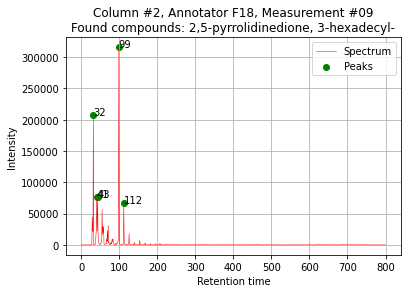

In [228]:
%matplotlib inline
plot_spectrum(X[0], metadata.iloc[0])

In [254]:
X = preprocessing.normalize(X, norm='l2', axis=1)

In [248]:
X_norm.sum(1)

array([1.       , 0.9999999, 1.       , ..., 1.       , 1.0000001,
       1.0000001], dtype=float32)

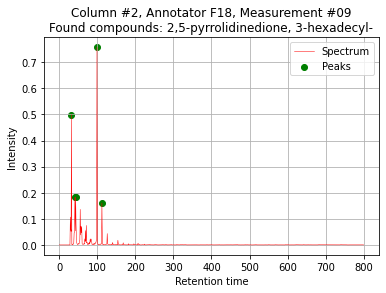

In [255]:
plot_spectrum(X[0], metadata.iloc[0])

### Split into training and testing data

In [256]:
start = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(f"Data splitted in {(time.time() - start):.1f} seconds.")

Data splitted in 0.0 seconds.


# Dot product the spectrums

In [257]:
def predict(train_data_points, test_data_points, train_labels):
    products = test_data_points @ train_data_points.T
    predictions = train_labels[products.argmax(axis=1)]
    return predictions

# Evaluation of a model
* metrics - accuracy, precision, recall, f1-score

In [258]:
dot_product_pred = predict(X_train, X_test, y_train)
accuracy = accuracy_score(y_test, dot_product_pred)

print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.82


# Cross-validation

In [259]:
from tqdm import tqdm

k = 5
folds_X = np.array_split(X, k) 
folds_y = np.array_split(y, k)
folds_acc = []
with tqdm(range(k), unit="k-fold") as k_fold:
    for i in k_fold:
        train_x = folds_X.copy() # you want to work on a copy of your array
        test_x = folds_X[i]
        del train_x[i]
        train_x = np.vstack((train_x))
        train_y = folds_y.copy() # you want to work on a copy of your array
        test_y = folds_y[i]
        del train_y[i]
        train_y = np.hstack((train_y))
        dot_product_pred = predict(train_x.copy(), test_x.copy(), train_y.copy())
        accuracy = accuracy_score(test_y.copy(), dot_product_pred.copy())
        folds_acc.append(accuracy)
        k_fold.set_postfix(accuracy = 100. * accuracy.item())
print(f"{k}-fold Cross Validation scores: {folds_acc}, mean: {np.mean(folds_acc)}")

100%|██████████| 5/5 [00:05<00:00,  1.06s/k-fold, accuracy=81.2]

5-fold Cross Validation scores: [0.8092189500640204, 0.8164746052069995, 0.8017498932991891, 0.8032437046521553, 0.8117797695262484], mean: 0.8084933845497225
